In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
from RRNN import RRNN
import matplotlib.pyplot as plt

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH
/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



### Différences dans les courbes d'accord

Par un ajustement de la distribution de Von Mises aux taux de décharge de la population excitatrice, nous tentons maintenant de montrer, de façon plus quantitative, l'effet de chacun des deux types de connectivité.

Nous simulons donc le ring feed-forward et le ring récurrent avec différentes entrées, des distributions d'orientation ayant différentes largeurs de bande. Pour chacun des deux types de ring, nous mesurons le taux de décharge moyen de la population excitatrice et nous ajustons ensuite ces taux de décharge par des distributions de Von Mises.

In [2]:
net = RRNN(ring=True, recurrent=True)

In [3]:
net.sim_params['b_input']

10.0

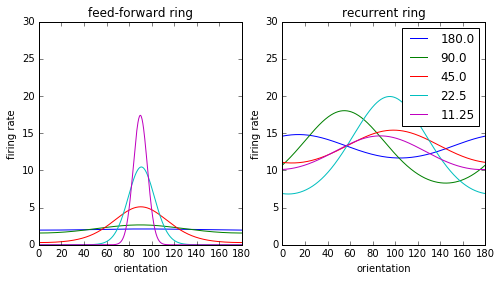

In [4]:
bw_values = 180*np.logspace(0, -4, 5, base=2)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    for bw_value in bw_values:
        if i==0:
            net = RRNN(ring=True, recurrent=False)
        else:
            net = RRNN(ring=True, recurrent=True)

        net.sim_params['b_input'] = bw_value
        df, spikesE, spikesI = net.model()
        theta, fr, result = net.fit_vonMises(spikesE)
        #print(result.best_fit.mean())
        axs[i].plot(theta*180/np.pi, result.best_fit, label=str(bw_value))

    axs[i].set_xlabel('orientation')
    axs[i].set_ylabel('firing rate')
    axs[i].axis('tight')
    axs[i].set_ylim([0, 30])
axs[0].set_title('feed-forward ring')
axs[1].set_title('recurrent ring')

plt.legend(loc='best')
plt.show()

fig.savefig('../figs/ring_feed-forward_vs_recurrent.png', dpi = 600)

In [5]:
bw_values = 180*np.logspace(-1, -10, 15, base=2)

def HWHH(k):
    """
    See http://motionclouds.invibe.net/posts/testing-grating.html#tuning-the-bandwidth
    
    """
    return .5*np.arccos(1+ np.log((1+np.exp(-2*k))/2)/k)

HWHH_in = HWHH(1/np.sqrt(bw_values/180*np.pi))

print(bw_values, HWHH_in)

[ 90.          57.63990104  36.91509102  23.64202437  15.14137717
   9.69719424   6.21050351   3.97747564   2.54734781   1.63143195
   1.04483973   0.66916065   0.42855949   0.27446807   0.17578125] [ 0.59984506  0.56160008  0.51928125  0.4743863   0.42891964  0.38492686
  0.3439743   0.30686562  0.27371709  0.24424961  0.21806033  0.19475953
  0.17400578  0.15550407  0.13899833]


In [6]:
BW= np.zeros((2, len(bw_values)))
for i in range(2):
    for i_bw, bw_value in enumerate(bw_values):
        if i==0:
            net = RRNN(ring=True, recurrent=False)
        else:
            net = RRNN(ring=True, recurrent=True)

        net.sim_params['b_input'] = bw_value
        
        df, spikesE, spikesI = net.model()
        theta, fr, result = net.fit_vonMises(spikesE)
        BW[i, i_bw] = result.params['sigma'].value

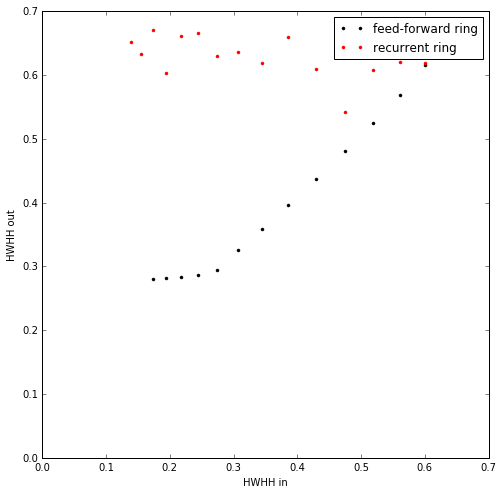

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(HWHH_in, HWHH(1/np.sqrt(BW[0, :])), 'k.', label='feed-forward ring')
ax.plot(HWHH_in, HWHH(1/np.sqrt(BW[1, :])), 'r.', label='recurrent ring')
        
ax.set_xlabel('HWHH in')
ax.set_ylabel('HWHH out')

plt.legend(loc='best')
ax.axis('tight')
ax.set_xlim([0, .7])
ax.set_ylim([0, .7])
plt.show()

fig.savefig('../figs/ring_feed-forward_vs_recurrent_BW.png', dpi = 600)